In [1]:
!pip install -q accelerate torch
!pip install -U scikit-learn
!pip install umap-learn
!pip install tqdm
!pip install datashader bokeh holoviews scikit-image colorcet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 72.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 84.2 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import pandas as pd
import numpy as np
import random

class MNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = dataframe['label']
        self.images = dataframe.drop('label', axis=1)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        anchor_label = self.labels.iloc[idx]
        anchor_image = self.images.iloc[idx].values.astype(np.uint8).reshape(28, 28)

        # Randomly sample a positive or negative example
        if random.random() > 0.5:  # Positive example
            positive_idx = self._get_positive_sample(anchor_label, idx)
            contrastive_image = self.images.iloc[positive_idx].values.astype(np.uint8).reshape(28, 28)
            distance = torch.tensor(1.0)  # Ideal distance for positive pair

        else:  # Negative example
            negative_idx = self._get_negative_sample(anchor_label)
            contrastive_image = self.images.iloc[negative_idx].values.astype(np.uint8).reshape(28, 28)
            distance = torch.tensor(0.0)  # Ideal distance for negative pair

        if self.transform:
            anchor_image = self.transform(anchor_image)
            contrastive_image = self.transform(contrastive_image)

        return anchor_image, contrastive_image, distance, anchor_label

    def _get_positive_sample(self, anchor_label, anchor_idx):
        # Find indices of all samples with the same label as the anchor
        positive_indices = self.dataframe[self.dataframe['label'] == anchor_label].index.tolist()
        # Remove the anchor index itself from the positive indices
        positive_indices.remove(anchor_idx)
        # Randomly select a positive sample index
        return random.choice(positive_indices)

    def _get_negative_sample(self, anchor_label):
        # Find indices of all samples with a different label than the anchor
        negative_indices = self.dataframe[self.dataframe['label'] != anchor_label].index.tolist()
        # Randomly select a negative sample index
        return random.choice(negative_indices)

In [7]:
# # Import neural network training libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Import basic computation libraries along with data visualization and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
import umap
import umap.plot
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'iframe'

# Import our data class which will organize MNIST and provide anchor, positive and negative samples.
# from mnist_dataset import MNISTDataset

In [5]:
# Load data from csv
data = pd.read_csv('train.csv')
val_count = 1000
# common transformation for both val and train
default_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# Split data into val and train
dataset = MNISTDataset(data.iloc[:-val_count], default_transform)
val_dataset = MNISTDataset(data.iloc[-val_count:], default_transform)

In [8]:
# Create torch dataloaders
trainLoader = DataLoader(
    dataset,
    batch_size=16, # modify this value when needed
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

valLoader = DataLoader(val_dataset,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    prefetch_factor=100
)

# Visualize datapoints

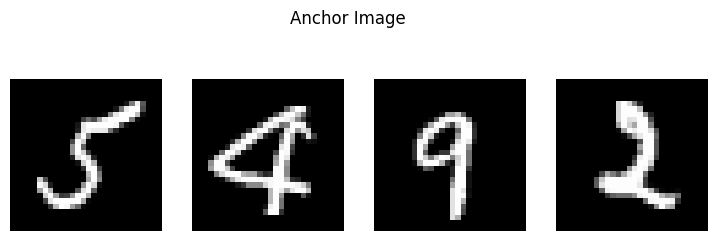

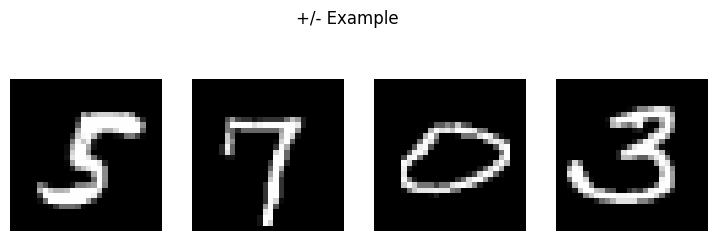

In [9]:
# Function to display images with labels
def show_images(images, title=''):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(9, 3))
    for i in range(num_images):
        img = np.squeeze(images[i])
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
    fig.suptitle(title)
    plt.show()

# Visualize some examples
for batch_idx, (anchor_images, contrastive_images, distances, labels) in enumerate(trainLoader):
    # Convert tensors to numpy arrays
    anchor_images = anchor_images.numpy()
    contrastive_images = contrastive_images.numpy()
    labels = labels.numpy()

    # Display some samples from the batch
    show_images(anchor_images[:4], title='Anchor Image')
    show_images(contrastive_images[:4], title='+/- Example')

    # Break after displaying one batch for demonstration
    break


# Build Neural Network Architecture

In [10]:
# Define a neural network architecture with two convolution layers and two fully connected layers
# Input to the network is an MNIST image and Output is a 64 dimensional representation.
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2, 2), stride=2),
            nn.Dropout(0.3)
        )
        self.linear1 = nn.Sequential(
            nn.Linear(64 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 64),
        )

    def forward(self, x):
        x = self.conv1(x) # x: d * 32 * 12 * 12
        x = self.conv2(x) # x: d * 64 * 4  * 4
        x = x.view(x.size(0), -1) # x: d * (64*4*4)
        x = self.linear1(x) # x: d * 64
        return x

# Contrastive Loss Function

In [11]:
# The ideal distance metric for a positive sample is set to 1, for a negative sample it is set to 0
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.similarity = nn.CosineSimilarity(dim=-1, eps=1e-7)

    def forward(self, anchor, contrastive, distance):
        # use cosine similarity from torch to get score
        score = self.similarity(anchor, contrastive)
        # after cosine apply MSE between distance and score
        return nn.MSELoss()(score, distance) #Ensures that the calculated score is close to the ideal distance (1 or 0)

In [12]:
# Training Configuration
net = Network()

device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda:0')

net = net.to(device)
device

'cpu'

In [13]:
# Define the training configuration
optimizer = optim.Adam(net.parameters(), lr=0.005)
loss_function = ContrastiveLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.3)

In [42]:
# Training Loop
import os

# Define a directory to save the checkpoints
checkpoint_dir = 'checkpoints/model.pth'

# Ensure the directory exists
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Model Training

In [48]:
def train_model(epoch_count=10):
    net = Network()
    lrs = []
    losses = []

    # Define a directory to save the checkpoints
    checkpoint_dir = 'checkpoints'
    # Ensure the directory exists
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(epoch_count):
        epoch_loss = 0
        batches=0
        print('epoch -', epoch)
        lrs.append(optimizer.param_groups[0]['lr'])
        print('learning rate', lrs[-1])

        for anchor, contrastive, distance, label in tqdm(trainLoader):
            batches += 1
            optimizer.zero_grad()
            anchor_out = net(anchor.to(device))
            contrastive_out = net(contrastive.to(device))
            distance = distance.to(torch.float32).to(device)
            loss = loss_function(anchor_out, contrastive_out, distance)
            epoch_loss += loss
            loss.backward()
            optimizer.step()

        losses.append(epoch_loss.cpu().detach().numpy() / batches)
        scheduler.step()
        print('epoch_loss', losses[-1])

        # Save a checkpoint of the model
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch}.pt')
        torch.save(net.state_dict(), checkpoint_path)

    return {
        "net": net,
        "losses": losses
    }

In [49]:
import os
import shutil

# Remove the conflicting directory if it exists
if os.path.isdir('checkpoints/model.pth'):
    shutil.rmtree('checkpoints/model.pth')
    print("Removed conflicting directory 'checkpoints/model.pth'.")

# Create the checkpoints folder if it doesn't exist
os.makedirs('checkpoints', exist_ok=True)

In [50]:
# Get the Model

def load_model_from_checkpoint():
    checkpoint_path = 'checkpoints/model.pth'
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file '{checkpoint_path}' does not exist. Train the model first by setting train=True.")

    checkpoint = torch.load(checkpoint_path)
    net = Network()
    net.load_state_dict(checkpoint)
    net.eval()
    return net

In [51]:
train = True  # Set to True to train and create the checkpoint also set False if we have the proper backupcheckpoint -model.pth

if train:
    training_result = train_model()
    model = training_result["net"]
else:
    model = load_model_from_checkpoint()

epoch - 0
learning rate 0.005


  0%|          | 0/45 [00:00<?, ?it/s]

epoch_loss 0.25595123
epoch - 1
learning rate 0.005


  0%|          | 0/45 [00:00<?, ?it/s]

epoch_loss 0.25604632
epoch - 2
learning rate 0.005


  0%|          | 0/45 [00:00<?, ?it/s]

epoch_loss 0.26270613
epoch - 3
learning rate 0.005


  0%|          | 0/45 [00:00<?, ?it/s]

epoch_loss 0.26335624
epoch - 4
learning rate 0.005


  0%|          | 0/45 [00:00<?, ?it/s]

epoch_loss 0.26960948
epoch - 5
learning rate 0.005


  0%|          | 0/45 [00:00<?, ?it/s]

epoch_loss 0.26063353
epoch - 6
learning rate 0.0015


  0%|          | 0/45 [00:00<?, ?it/s]

epoch_loss 0.25898835
epoch - 7
learning rate 0.0015


  0%|          | 0/45 [00:00<?, ?it/s]

epoch_loss 0.26351443
epoch - 8
learning rate 0.0015


  0%|          | 0/45 [00:00<?, ?it/s]

epoch_loss 0.2605416
epoch - 9
learning rate 0.0015


  0%|          | 0/45 [00:00<?, ?it/s]

epoch_loss 0.2544768


# Visualize the loss curve for your trained model

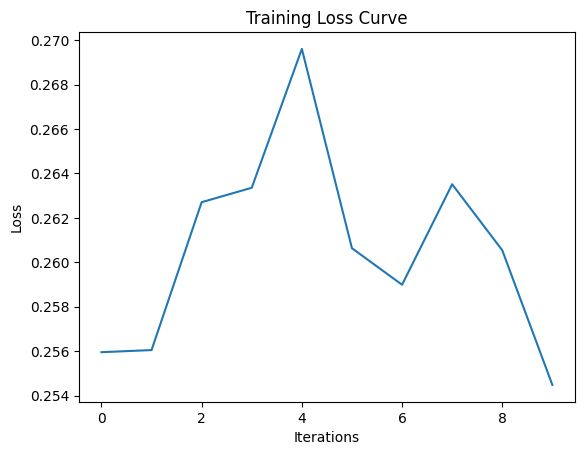

In [52]:
import os
from IPython.display import Image
import matplotlib.pyplot as plt

os.makedirs('images', exist_ok=True)  # Create images folder if needed

if train:
    # Show and save loss curve from training
    plt.plot(training_result["losses"])
    plt.title("Training Loss Curve")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.savefig("images/loss-curve.png")
    plt.show()
else:
    # If loading a checkpoint, display the pre-saved loss curve
    display(Image(filename="images/loss-curve.png", height=600, width=600))

# Visualize the Vector Space!

In [53]:
encoded_data = []
labels = []

with torch.no_grad():
    for anchor, _, _, label in tqdm(trainLoader):
        output = model(anchor.to(device))
        encoded_data.extend(output.cpu().numpy())
        labels.extend(label.cpu().numpy())

encoded_data = np.array(encoded_data)
labels = np.array(labels)

  0%|          | 0/45 [00:00<?, ?it/s]

Reduce Dimensionality of Data

In [54]:
# Apply PCA to reduce dimensionality of data from 64dimension -> 3d to make it easier to visualize!
pca = PCA(n_components=3)
encoded_data_3d = pca.fit_transform(encoded_data)

In [61]:
scatter = go.Scatter3d(
    x=encoded_data_3d[:, 0],
    y=encoded_data_3d[:, 1],
    z=encoded_data_3d[:, 2],
    mode='markers',
    marker=dict(size=4, color=labels, colorscale='Viridis', opacity=0.8),
    text=labels,
    hoverinfo='text',
)

# Create layout
layout = go.Layout(
    title="MNIST Dataset - Encoded and PCA Reduced 3D Scatter Plot",
    scene=dict(
        xaxis=dict(title="PC1"),
        yaxis=dict(title="PC2"),
        zaxis=dict(title="PC3"),
    ),
    width=1000,
    height=750,
)

# Create figure and add scatter plot
fig = go.Figure(data=[scatter], layout=layout)

# Set the renderer to 'colab' which is compatible with Google Colab
pio.renderers.default = 'colab'

# Show the plot
fig.show()

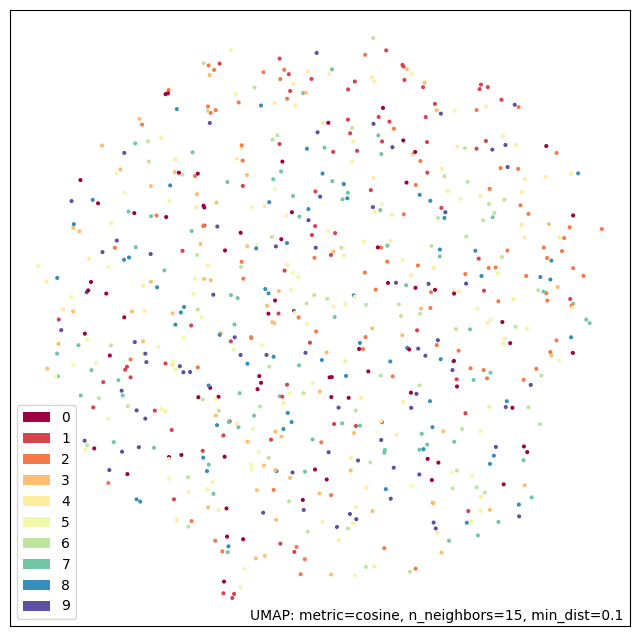

In [62]:
# Scatterplot in 2d - with UMAP
mapper = umap.UMAP(random_state=42, metric='cosine').fit(encoded_data)
umap.plot.points(mapper, labels=labels);

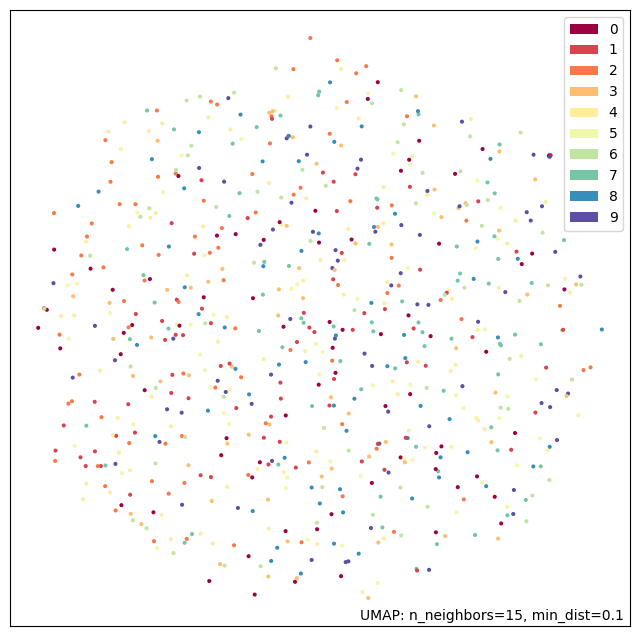

In [57]:
mapper = umap.UMAP(random_state=42).fit(encoded_data)  #  UMAP with Euclidian Metric
umap.plot.points(mapper, labels=labels);